<a href="https://colab.research.google.com/github/Nudrat-Habib/deep-learning-model-on-CIFAR10-dataset-/blob/main/DL_with_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

We can download the data and create a PyTorch dataset using the CIFAR10 class from torchvision.datasets.

In [ ]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())

Files already downloaded and verified


In [ ]:
num_classes=dataset.classes
num_classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

image.shape: torch.Size([3, 32, 32])
permuted image shape torch.Size([32, 32, 3])
Label: 1 class: automobile


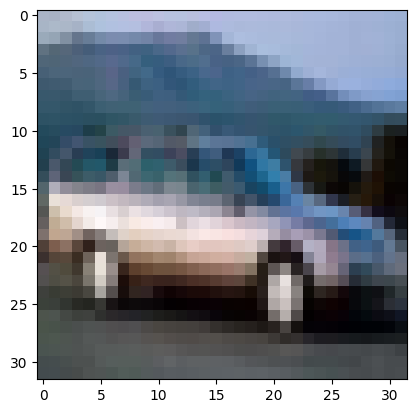

In [ ]:
image, label = dataset[4]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray') #permute is used to change the dimension. plt expects color channel as last dimension.
print('permuted image shape',image.permute(1,2,0).shape)
print('Label:', label,'class:',num_classes[label])

image.shape: torch.Size([3, 32, 32])
permuted image shape torch.Size([32, 32, 3])
Label: 2 class bird


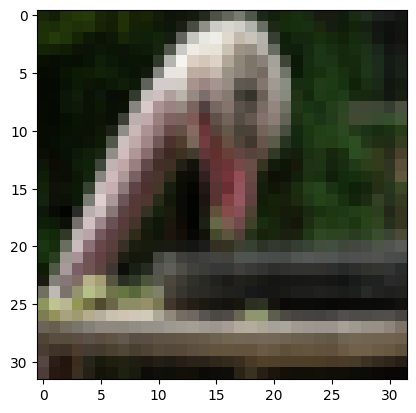

In [ ]:
image, label = dataset[400]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray') #permute is used to change the dimension. plt expects color channel as last dimension.
print('permuted image shape',image.permute(1,2,0).shape)
print('Label:', label,'class',num_classes[label])

let's just check the length of dataset before applynig random split to divide data into traing and evaluation.

In [ ]:
len(dataset)

50000

let's just write a code to sum images per class

In [ ]:
images_per_class={}
for img,label in dataset:
  category=num_classes[label]
  if category not in images_per_class:
    images_per_class[category]=1
  else: images_per_class[category]+=1

images_per_class


{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

In [ ]:
val_size=5000
train_size=len(dataset)-val_size
train_ds,val_ds=random_split(dataset,(train_size,val_size))
print(len(train_ds),len(val_ds))

45000 5000


In [ ]:
batch_size=128
train_loader=DataLoader(train_ds,batch_size,shuffle='True',num_workers=2)
val_loader=DataLoader(val_ds,batch_size*2,num_workers=2)

now we plot whole batch of images at once using make_grid function of pytorch

images.shape: torch.Size([128, 3, 32, 32])


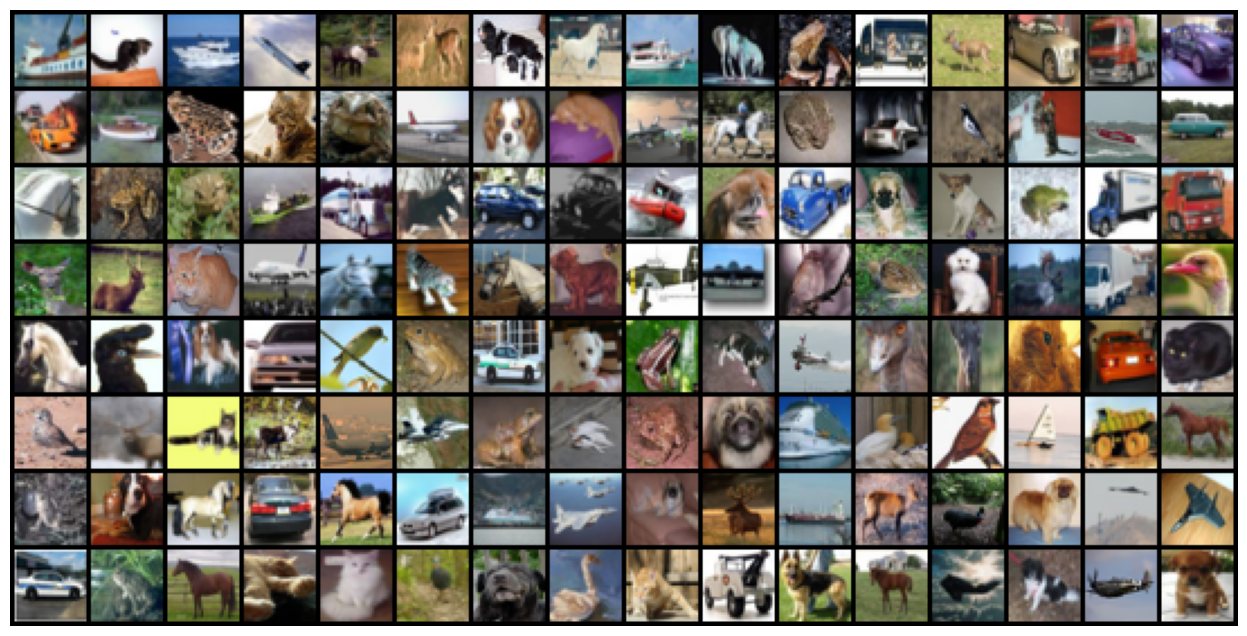

In [ ]:
for images, label in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
input_size=3*32*32 # must be the input size of first layer
output_size=10 #must be the output size of last layer.
input_size

3072

Typically, a batch of images is represented as a 4-dimensional tensor with the dimensions (batch_size, channels, height, width), where:

batch_size is the number of images in the batch.
channels represents the color channels (e.g., 3 for RGB images).
height and width are the dimensions of each image.
xb.size(0) retrieves the size (number of elements) of the first dimension of the tensor xb. In this context, it corresponds to the batch size.

-1 is a special value used in PyTorch's view method. When you use -1 as one of the dimensions, it's inferred by PyTorch based on the size of the original tensor and the other specified dimensions. In this case, using -1 means "flatten the tensor while preserving the batch size."

In [ ]:
class CIFAR10Model(nn.Module):
  def __init__(self,input_size,output_size):
    super().__init__()
    self.Linear1=nn.Linear(input_size,2048)
    self.Linear2=nn.Linear(2048,1024)
    self.Linear3=nn.Linear(1024,512)
    self.Linear4=nn.Linear(512,256)
    self.Linear5=nn.Linear(256,128)
    self.Linear6=nn.Linear(128,64)
    self.Linear7=nn.Linear(64,32)
    self.Linear8=nn.Linear(32,output_size)

  def forward(self,xb):

    #flatten the images
    xb = xb.view(xb.size(0), -1)

    #pass the images through first linear layer
    out=self.Linear1(xb)

    #pass the output of first linear layer through Relu activation function
    out=F.relu(out)

    #pass the images through second linear layer and then Activation funtion
    out=self.Linear2(out)
    out=F.relu(out)

    #pass the images through third linear layer and the AF
    out=self.Linear3(out)
    out=F.relu(out)

    #pass the images through fourth linear layer and AF
    out=self.Linear4(out)
    out=F.relu(out)

    #pass the images through fourth linear layer and AF
    out=self.Linear5(out)
    out=F.relu(out)
    out=self.Linear6(out)
    out=F.relu(out)
    out=self.Linear7(out)
    out=F.relu(out)
    out=self.Linear8(out)
    return out
  def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

  def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

  def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))





In [ ]:
model=CIFAR10Model(input_size,output_size)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:

def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
    history=[]
    optimizer=opt_func(model.parameters(),lr,momentum=0.9)
    for epoch in range(epochs):
      for batch in train_loader:
      #training phase
        loss=model.training_step(batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

      #validation phase
      result=evaluate(model,val_loader)
      model.epoch_end(epoch, result)
      history.append(result)
    return history




In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3070101737976074, 'val_acc': 0.10243566334247589}]

In [ ]:
history +=fit(30,.1,model,train_loader,val_loader)

Epoch [0], val_loss: 2.2907, val_acc: 0.1091
Epoch [1], val_loss: 2.0527, val_acc: 0.1836
Epoch [2], val_loss: 1.9932, val_acc: 0.2205
Epoch [3], val_loss: 2.0155, val_acc: 0.2507
Epoch [4], val_loss: 1.8944, val_acc: 0.2920
Epoch [5], val_loss: 1.9076, val_acc: 0.2835
Epoch [6], val_loss: 1.8434, val_acc: 0.3197
Epoch [7], val_loss: 1.8565, val_acc: 0.2818
Epoch [8], val_loss: 1.7181, val_acc: 0.3764
Epoch [9], val_loss: 1.7233, val_acc: 0.3790
Epoch [10], val_loss: 1.7038, val_acc: 0.3996
Epoch [11], val_loss: 1.7507, val_acc: 0.3838
Epoch [12], val_loss: 1.6831, val_acc: 0.3745
Epoch [13], val_loss: 1.6572, val_acc: 0.4121
Epoch [14], val_loss: 1.6425, val_acc: 0.3983
Epoch [15], val_loss: 1.6505, val_acc: 0.4053
Epoch [16], val_loss: 1.6985, val_acc: 0.4206
Epoch [17], val_loss: 1.6706, val_acc: 0.4248
Epoch [18], val_loss: 1.6771, val_acc: 0.4204
Epoch [19], val_loss: 1.6067, val_acc: 0.4296
Epoch [20], val_loss: 1.6380, val_acc: 0.4124
Epoch [21], val_loss: 1.5752, val_acc: 0.442

we achieved accuracy of 46 percent in 30 epochs.
accuracy can further be increased by applying different techniques like:
1. by preprocessing
2. Model architecture: increasing, decresing number of layers, input output features at each layer.
3. loss function: different loss functions are avialble which can be used to see the result on accuracy
4. hyperparameter tuning: Tune hyperparameters such as learning rate, batch size, and the number of epochs using techniques like grid search, random search, or Bayesian optimization.


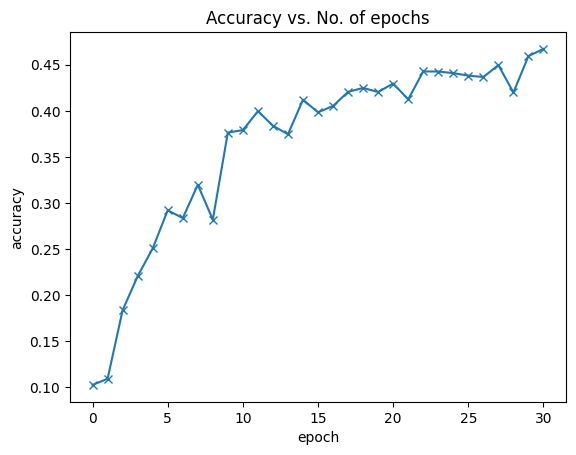

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

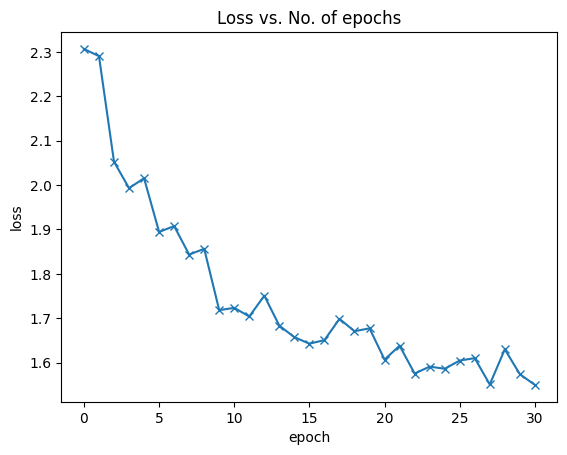

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [ ]:
# Define test dataset
test_dataset = CIFAR10(root='data/',
                     train=False,
                     transform=ToTensor())

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: ship , Predicted: ship


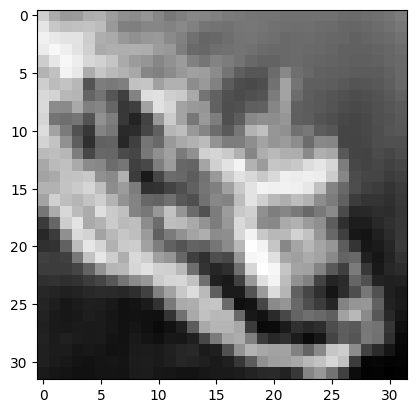

In [ ]:
img, label = test_dataset[15]
plt.imshow(img[0], cmap='gray')
print('Label:', num_classes[label], ', Predicted:', num_classes[predict_image(img, model)])